In [ ]:
import pandas as pd
import numpy as np
import os


def read_data(data_path, split_type="train", shuffle=False, sub_split=False):
    """
    Read data in from CSV files and format properly for neural networks.

    :param data_path: Absolute file path to data.
    :param split_type: If splitting the same dataset, which split to designate this one as.
    :param shuffle: Whether data should be kept in sequential order or shuffled.
    :param sub_split: Should the data be split in half and returned as a two-tuple.
    :return: Data formatted for neural network training.
    """
    # Fixed params
    n_class = 6
    n_channels = 2
    n_steps = 2496

    train_days = [1, 2, 3]
    test_days = [1, 2, 3]

    if split_type == 'train':
        split = train_days
    else:
        split = test_days

    # Assign numeric label to categories:
    #
    # cyl = 1
    # hook = 2
    # lat = 3
    # palm = 4
    # spher = 5
    # tip = 6
    #
    labels = np.concatenate(
        (
            [[class_id for _ in range(100 * len(split))] for class_id in range(1, n_class + 1)]
        )
    )

    files = [
        'cyl_ch1.csv',
        'cyl_ch2.csv',
        'hook_ch1.csv',
        'hook_ch2.csv',
        'lat_ch1.csv',
        'lat_ch2.csv',
        'palm_ch1.csv',
        'palm_ch2.csv',
        'spher_ch1.csv',
        'spher_ch2.csv',
        'tip_ch1.csv',
        'tip_ch2.csv'
    ]

    # Merge files of different grip types into one long file, per channel
    channels = []
    for num_channel in range(n_channels):

        all_of_channel = []
        for file in files[num_channel::n_channels]:

            gesture_by_day = []
            for day in split:
                full_day_path = os.path.join(data_path, 'male_day_%d' % day)
                full_file_path = os.path.join(full_day_path, file)

                # Drop last 4 data points to more easily subdivide into layers
                gesture_by_day.append(pd.read_csv(full_file_path,  header=None).drop(labels=[2496, 2497, 2498, 2499], axis=1))

            all_of_channel.append(pd.concat(gesture_by_day))

        channels.append(
            (pd.concat(all_of_channel), 'channel_%d' % num_channel)
        )

    # Initiate array
    list_of_channels = []
    X = np.zeros((len(labels), n_steps, n_channels))

    i_ch = 0
    for channel_data, channel_name in channels:
        X[:, :, i_ch] = channel_data.values
        
        list_of_channels.append(channel_name)
        i_ch += 1

    if shuffle:
        shuff_labels = np.zeros((len(labels), 1, n_channels))
        shuff_labels[:, 0, 0] = labels
        shuff_labels[:, 0, 1] = labels

        new_data = np.concatenate([shuff_labels, X], axis=1)

        np.reshape(new_data, (n_steps + 1, len(labels), n_channels))
        np.random.shuffle(new_data)
        np.reshape(new_data, (len(labels), n_steps + 1, n_channels))

        final_data = new_data[:, 1:, :]
        final_labels = np.array(new_data[:, 0, 0]).astype(int)

        # Return (train, test)
        if sub_split:
            return (
                final_data[int(len(final_labels) / 2):, :, :],
                final_labels[int(len(final_labels) / 2):],
                list_of_channels,
                final_data[:int(len(final_labels) / 2), :, :],
                final_labels[:int(len(final_labels) / 2)],
                list_of_channels
            )
        else:
            return final_data, final_labels, list_of_channels

    else:
        return X, labels, list_of_channels


def standardize(train, test):
    """
    Standardize data.

    :param train: Train data split.
    :param test: Test data split.
    :return: Normalized data set.
    """

    # Standardize train and test
    X_train = (train - np.mean(train, axis=0)[None, :, :]) / np.std(train, axis=0)[None, :, :]
    X_test = (test - np.mean(test, axis=0)[None, :, :]) / np.std(test, axis=0)[None, :, :]

    return X_train, X_test


def one_hot(labels, n_class=6):
    """
    One-hot encoding.

    :param labels: Labels to encode.
    :param n_class: Number of classes.
    :return: One-hot encoded labels.
    """
    expansion = np.eye(n_class)
    y = expansion[:, labels-1].T

    assert y.shape[1] == n_class, "Wrong number of labels!"

    return y


def get_batches(X, y, batch_size=100):
    """
    Return a generator for batches.

    :param X: Data set.
    :param y: Labels.
    :param batch_size: Batch size.
    :return: Portion of data in batch-size increments.
    """
    n_batches = len(X) // batch_size
    X, y = X[:n_batches * batch_size], y[:n_batches * batch_size]

    # Loop over batches and yield
    for b in range(0, len(X), batch_size):
        yield X[b:b + batch_size], y[b:b + batch_size]


In [ ]:
import numpy as np
import os

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Read in data and split into train/test portions:

In [ ]:
path = os.path.abspath(os.getcwd())
X_train, labels_train, list_ch_train, X_test, labels_test, list_ch_test = read_data(
    data_path='%s%sdrive/MyDrive/sEMG-Neural-Net-master/sEMG%sDatabase 2%s' % (path, os.sep, os.sep, os.sep),    #séparé avec / hada wesh me3nato
    shuffle=True,
    sub_split=True
)

assert list_ch_train == list_ch_test, 'Mismatch in channels!'


In [ ]:
X_train, X_test = standardize(X_train, X_test)

Train/validation split using sklearn utility. Manually specify random state seed to make testing more deterministic.


In [ ]:
X_tr, X_vld, lab_tr, lab_vld = train_test_split(
    X_train,
    labels_train, 
    stratify=labels_train,
    random_state=123
)

In [ ]:
y_tr = one_hot(lab_tr)
y_vld = one_hot(lab_vld)
y_test = one_hot(labels_test)

## Initialize Tensorflow + Hyperparameters

In [ ]:
import tensorflow as tf

# The following were determined through iterative trial and error:
batch_size = 100
seq_len = 2496
learning_rate = 0.00001
epochs = 2500

n_classes = 6
n_channels = 2

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


## Construct Graph
Placeholders:

In [ ]:
graph = tf.Graph()

with graph.as_default():
    inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name='inputs')
    labels_ = tf.placeholder(tf.float32, [None, n_classes], name='labels')
    keep_prob_ = tf.placeholder(tf.float32, name='keep')
    learning_rate_ = tf.placeholder(tf.float32, name='learning_rate')

## Build Convolutional Layers


In [ ]:
with graph.as_default():
    
    # (batch, 2496, 2) --> (batch, 1248, 4)
    conv1 = tf.layers.conv1d(
        inputs=inputs_,
        filters=4,
        kernel_size=2,
        strides=1, 
        padding='same',
        activation=tf.nn.relu
    )
    max_pool_1 = tf.layers.max_pooling1d(inputs=conv1, pool_size=2, strides=2, padding='same')
    
    # (batch, 1248, 4) --> (batch, 624, 8)
    conv2 = tf.layers.conv1d(
        inputs=max_pool_1,
        filters=8,
        kernel_size=2,
        strides=1,          
        padding='same',
        activation=tf.nn.relu
    )
    max_pool_2 = tf.layers.max_pooling1d(inputs=conv2, pool_size=2, strides=2, padding='same')
    
    # (batch, 624, 8) --> (batch, 312, 16)
    conv3 = tf.layers.conv1d(
        inputs=max_pool_2,
        filters=16,
        kernel_size=2,
        strides=1,
        padding='same',
        activation=tf.nn.relu
    )
    max_pool_3 = tf.layers.max_pooling1d(inputs=conv3, pool_size=2, strides=2, padding='same')
    
    # (batch, 312, 16) --> (batch, 156, 32)
    conv4 = tf.layers.conv1d(
        inputs=max_pool_3,
        filters=32,
        kernel_size=2,
        strides=1,
        padding='same',
        activation = tf.nn.relu
    )
    max_pool_4 = tf.layers.max_pooling1d(inputs=conv4, pool_size=2, strides=2, padding='same')
    
    # (batch, 156, 32) --> (batch, 78, 64)
    conv5 = tf.layers.conv1d(
        inputs=max_pool_4,
        filters=64,
        kernel_size=2,
        strides=1,
        padding='same',
        activation = tf.nn.relu
    )
    max_pool_5 = tf.layers.max_pooling1d(inputs=conv5, pool_size=2, strides=2, padding='same')
    
    # (batch, 78, 64) --> (batch, 39, 128)
    conv6 = tf.layers.conv1d(
        inputs=max_pool_5,
        filters=128,
        kernel_size=2,
        strides=1,
        padding='same',
        activation = tf.nn.relu
    )
    max_pool_6 = tf.layers.max_pooling1d(inputs=conv6, pool_size=2, strides=2, padding='same')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `tf.layers.conv1d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv1D` instead.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `tf.layers.max_pooling1d` is deprecated and will be removed in a future version. Please use `tf.keras.layers.MaxPooling1D` instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: `tf.layers.conv1d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv1D` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: `tf.layers.max_pooling1d` is deprecated and will be removed in a future version. Please use `tf.keras.layers.MaxPooling1D` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: `tf.layers.conv1d` is deprecat

Pass to classifier:

In [ ]:
with graph.as_default():
    # Reshape, add dropout (dimensions match final convultional layer)
    flat = tf.reshape(max_pool_6, (-1, 128 * 39))
    flat = tf.nn.dropout(flat, keep_prob=keep_prob_)
    
    # Predictions
    logits = tf.layers.dense(flat, n_classes)
    
    # Cost and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_))
    optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost)
    
    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  import sys
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



## Train the network

In [ ]:
if (os.path.exists('checkpoints-cnn') == False):
    !mkdir checkpoints-cnn

In [ ]:
validation_acc = []
validation_loss = []

train_acc = []
train_loss = []

with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
   
    # Loop over epochs
    for e in range(epochs):
        
        # Loop over batches
        for x,y in get_batches(X_tr, y_tr, batch_size):
            
            # Feed dictionary
            feed = {inputs_: x, labels_: y, keep_prob_: 0.5, learning_rate_: learning_rate}
            
            # Loss
            loss, _, acc = sess.run([cost, optimizer, accuracy], feed_dict=feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            # Print at each 5 iterations
            if (iteration % 5 == 0):
                print(
                    'Epoch: {}/{}'.format(e, epochs),
                    'Iteration: {:d}'.format(iteration),
                    'Train loss: {:6f}'.format(loss),
                    'Train acc: {:.6f}'.format(acc)
                )
            
            # Compute validation loss at every 10 iterations
            if (iteration % 10 == 0):                
                val_acc_ = []
                val_loss_ = []
                
                for x_v, y_v in get_batches(X_vld, y_vld, batch_size):
                    
                    # Feed
                    feed = {inputs_: x_v, labels_: y_v, keep_prob_: 1.0}  
                    
                    # Loss
                    loss_v, acc_v = sess.run([cost, accuracy], feed_dict=feed)                    
                    val_acc_.append(acc_v)
                    val_loss_.append(loss_v)
                
                # Display info
                print(
                    'Epoch: {}/{}'.format(e, epochs),
                    'Iteration: {:d}'.format(iteration),
                    'Validation loss: {:6f}'.format(np.mean(val_loss_)),
                    'Validation acc: {:.6f}'.format(np.mean(val_acc_))
                )
                
                # Store
                validation_acc.append(np.mean(val_acc_))
                validation_loss.append(np.mean(val_loss_))
            
            iteration += 1
    
    saver.save(sess,'checkpoints-cnn/semg.ckpt')

Epoch: 0/2500 Iteration: 5 Train loss: 1.812842 Train acc: 0.120000
Epoch: 1/2500 Iteration: 10 Train loss: 1.861056 Train acc: 0.120000
Epoch: 1/2500 Iteration: 10 Validation loss: 1.803879 Validation acc: 0.195000
Epoch: 2/2500 Iteration: 15 Train loss: 1.817527 Train acc: 0.190000
Epoch: 3/2500 Iteration: 20 Train loss: 1.820924 Train acc: 0.120000
Epoch: 3/2500 Iteration: 20 Validation loss: 1.794679 Validation acc: 0.195000
Epoch: 4/2500 Iteration: 25 Train loss: 1.794356 Train acc: 0.160000
Epoch: 4/2500 Iteration: 30 Train loss: 1.788723 Train acc: 0.140000
Epoch: 4/2500 Iteration: 30 Validation loss: 1.786177 Validation acc: 0.195000
Epoch: 5/2500 Iteration: 35 Train loss: 1.776332 Train acc: 0.140000
Epoch: 6/2500 Iteration: 40 Train loss: 1.794137 Train acc: 0.150000
Epoch: 6/2500 Iteration: 40 Validation loss: 1.778305 Validation acc: 0.195000
Epoch: 7/2500 Iteration: 45 Train loss: 1.777736 Train acc: 0.160000
Epoch: 8/2500 Iteration: 50 Train loss: 1.774733 Train acc: 0.21

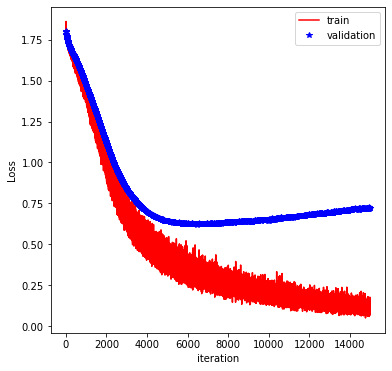

In [ ]:
# Plot loss
t = np.arange(iteration - 1)

plt.figure(figsize=(6, 6))
plt.plot(t, np.array(train_loss), 'r-', t[t % 10 == 0], np.array(validation_loss), 'b*')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

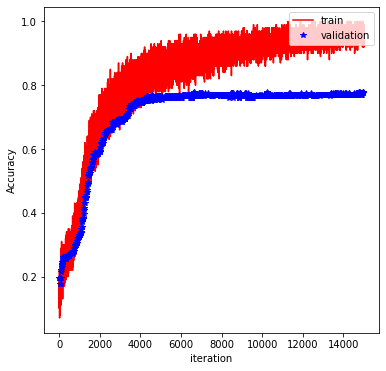

In [ ]:
# Plot Accuracies
plt.figure(figsize=(6, 6))

plt.plot(t, np.array(train_acc), 'r-', t[t % 10 == 0], validation_acc, 'b*')
plt.xlabel("iteration")
plt.ylabel("Accuracy")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Evaluate on test set

In [ ]:
test_acc = []

with tf.Session(graph=graph) as sess:
    # Restore checkpoint
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints-cnn'))
    
    # Dictionary in which to track accuracies based on grip
    accuracy_by_grip = [
        (
            'cylindrical',
            {
                'correct': 0,
                'total': 0
            }
        ),
        (
            'hook', 
            {
                'correct': 0, 
                'total': 0
            }
        ),
        (
            'lateral', 
            {
                'correct': 0, 
                'total': 0
            }
        ),
        (
            'palmar', 
            {
                'correct': 0, 
                'total': 0
            }
        ),
        (
            'spherical', 
            {
                'correct': 0, 
                'total': 0
            }
        ),
        (
            'tip', 
            {
                'correct': 0, 
                'total': 0
            }
        ),
    ]
    
    for x_t, y_t in get_batches(X_test, y_test, batch_size):
        feed = {
            inputs_: x_t,
            labels_: y_t,
            keep_prob_: 1
        }
        
        actual = y_t.argmax(axis=1)
        predicted = sess.run(tf.argmax(logits, 1), feed_dict=feed)
        
        for i in range(len(actual)):
            accuracy_by_grip[actual[i]][1]['total'] += 1
            if actual[i] == predicted[i]:
                accuracy_by_grip[actual[i]][1]['correct'] += 1
        
        batch_acc = sess.run(accuracy, feed_dict=feed)
        test_acc.append(batch_acc)
        
    print('Accuracy by grip:')
    
    for grip, grip_data in accuracy_by_grip:
        print('{}: {:.6f}'.format(grip, grip_data['correct'] / grip_data['total']))
        
    print('\nOverall accuracy: {:.6f}'.format(np.mean(test_acc)))
    

Accuracy by grip:
cylindrical: 0.919708
hook: 0.827586
lateral: 0.760563
palmar: 0.714286
spherical: 0.980000
tip: 0.689873

Overall accuracy: 0.811111
